# MLS-- project
#### By Student:
#### Rita Valciukiene, No: G00376585


#### Instructions:

In this project you must create a web service that uses machine learning to make predictions based on the data set powerproduction available on Moodle.
The goal: produce a model that accurately predicts wind turbine power output from wind speed values, as in the data set.
I must then develop a web service that will respond with predicted power values based on speed values sent as HTTP requests. 


I have to use few librarys ; for this project:

1. Jupyter notebook that trains a model using the data set. In the notebook you
should explain your model and give an analysis of its accuracy.
2. Python script that runs a web service based on the model, as above.
3. Dockerfile to build and run the web service in a container.


To start my project I have to import librarys. 

In [14]:
import pandas as pd # Imported pandas for data frames.
import seaborn as sns
import matplotlib.pyplot as plt


In [15]:
import math as m
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures # For generating polynomial features.
from sklearn.model_selection import train_test_split# Library for splitting data sets.
from sklearn.svm import SVR # Library for vector machine regression
from sklearn.preprocessing import StandardScaler
import joblib
import seaborn as sns

## Data set: Wind and Power representation

In [2]:
df = pd.read_csv("C:/Users/35385/Desktop/cmder/powerproduction.txt")

In [3]:
df

,speed,power
0,0.000,0.0
1,0.125,0.0
2,0.150,0.0
3,0.225,0.0
4,0.275,0.0
...,...,...
495,24.775,0.0
496,24.850,0.0
497,24.875,0.0
498,24.950,0.0


In [3]:
df.columns # The columns shows two column  names: Speed and power.

Index(['speed', 'power'], dtype='object')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 2 columns):
speed    500 non-null float64
power    500 non-null float64
dtypes: float64(2)
memory usage: 7.9 KB


In [5]:
df.shape # The shape shows than in this dataset 502 rows and 2 columns.

(500, 2)

In [6]:
df.describe()

,speed,power
count,500.000000,500.000000
mean,12.590398,48.014584
std,7.224991,41.614572
min,0.000000,0.000000
25%,6.324750,5.288000
50%,12.550500,41.645500
75%,18.775250,93.537000
max,25.000000,113.556000


In [7]:
df.isin([0]).sum()

speed     1
power    49
dtype: int64

In [8]:

 # Sorted data by speed. Adapted code in source [2].
df.sort_values(by=['speed']).head(20)

,speed,power
0,0.000,0.000
1,0.125,0.000
2,0.150,0.000
3,0.225,0.000
4,0.275,0.000
5,0.325,4.331
6,0.400,5.186
7,0.450,3.826
8,0.501,1.048
9,0.526,5.553


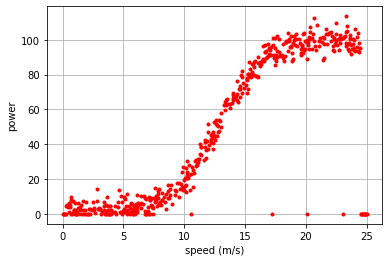

In [9]:
plt.plot(df['speed'], df['power'],  '.r') #  Plotted power of wind speed.
plt.xlabel('speed (m/s)', fontsize='10')
plt.ylabel('power', fontsize='10')
plt.grid()

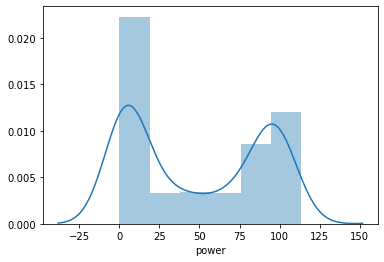

In [16]:

sns.distplot(df['power'])

###### Linear Regression?

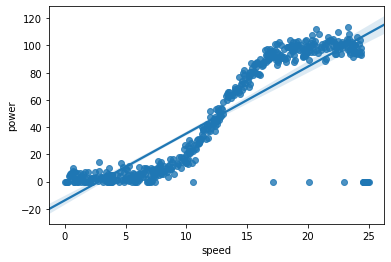

In [17]:
sns.regplot(x='speed',y='power',data = df)
plt.show()


###### What is KERAS?
Keras is a neural network library while TensorFlow is the open-source library for a number of various tasks in machine learning. TensorFlow provides both high-level and low-level APIs while Keras provides only high-level APIs. ... Both frameworks thus provide high-level APIs for building and training models with ease.

#### References
[2].https://pandas.pydata.org .DataFrame.sort values.